In [5]:
import os
import errno
import numpy as np 
import deepcell
import xarray as xr
from deepcell.applications import MultiplexSegmentation

In [2]:
test_data = np.load('/data/npz_data/20201018_freeze/20201018_multiplex_final_seed_1_test_256x256.npz')

In [12]:
X_test, y_test = test_data['X'], test_data['y']

In [7]:
app = MultiplexSegmentation(use_pretrained_weights=False)

In [8]:
# compartment
weights = "/data/models/20200619_production_updates/20201018_multiplex_final_seed_1_nuclear_deep_watershed.h5"

In [9]:
app.model.load_weights(weights)

In [7]:
output = app.predict(image=X_test, image_mpp=0.5, compartment='both', 
                     postprocess_kwargs_whole_cell={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.3,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3}, 
                     postprocess_kwargs_nuclear={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.3,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3,
                                                    'pixel_expansion': 3})

In [8]:
output_no_expansion = app.predict(image=X_test, image_mpp=0.5, compartment='nuclear', 
                     
                     postprocess_kwargs_nuclear={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.3,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3,
                                                    'pixel_expansion': 0})

In [11]:
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay
RGB_data = create_rgb_image(X_test[:10], ['green', 'blue'])

In [13]:
predicted_overlay = make_outline_overlay(RGB_data, output[:10, :, :, :1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Predicted Overlay')

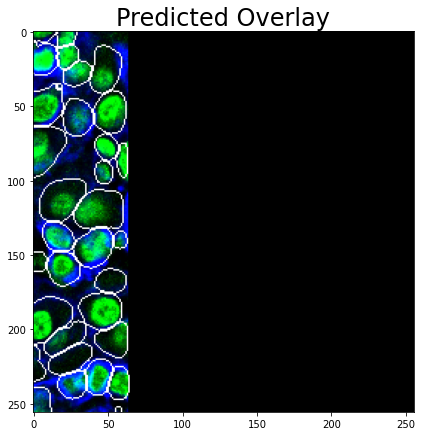

In [15]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 9
fig, axes = plt.subplots(figsize=(10,7))

axes.imshow(predicted_overlay[index, :, :, :], cmap=cmap)

axes.set_title('Predicted Overlay', fontsize=24)

In [18]:
# for test data evaluation
save_dir = '/data/segmentation/20201022_test_split/''
np.savez_compressed(save_dir + '20201018_multiplex_final_seed_1_test_cell_prediction.npz', y=output[..., :1])
np.savez_compressed(save_dir + '20201018_multiplex_final_seed_1_test_nuc_prediction.npz', y=output[..., 1:])
np.savez_compressed(save_dir + '20201018_multiplex_final_seed_1_test_nuc_expansion_prediction.npz', y=output_no_expansion)

In [31]:
data_dir = '/data/segmentation/20201004_figure_2_DCIS/'
test_data_image = xr.open_dataarray(data_dir + 'deepcell_input_new.xr')

In [10]:
output = app.predict(image=test_data_image.values, image_mpp=0.5, compartment='both', 
                     postprocess_kwargs_whole_cell={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.3,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3}, 
                     postprocess_kwargs_nuclear={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.3,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3,
                                                    'pixel_expansion': 0})

In [11]:
expansion_output = app.predict(image=test_data_image.values, image_mpp=0.5, compartment='nuclear', 
                     
                     postprocess_kwargs_nuclear={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.3,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3,
                                                    'pixel_expansion': 3})

In [13]:
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay
RGB_data = create_rgb_image(test_data_image.values, ['green', 'blue'])

In [27]:
cell_overlay = make_outline_overlay(RGB_data, output[:10, :, :, :1])
nuc_overlay = make_outline_overlay(RGB_data, output[:10, :, :, 1:])
expansion_overlay = make_outline_overlay(RGB_data, expansion_output[:10, :, :, :1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


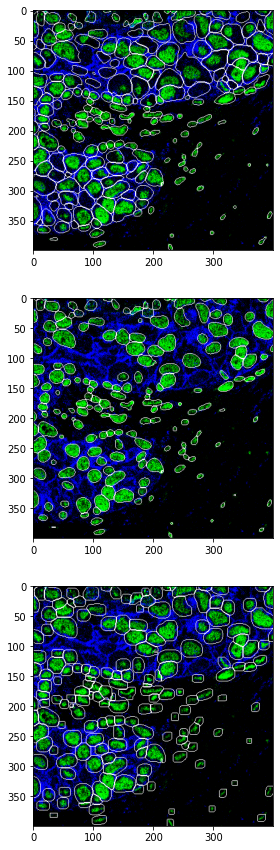

In [28]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
fig, axes = plt.subplots(3, 1, figsize=(15,15))

axes[0].imshow(cell_overlay[2, 200:600, 200:600, :], cmap=cmap)
axes[1].imshow(nuc_overlay[2, 200:600, 200:600, :], cmap=cmap)
axes[2].imshow(expansion_overlay[2, 200:600, 200:600, :], cmap=cmap)

In [32]:
segmentation_labels_cell = xr.DataArray(output[..., :1],
                         coords=[test_data_image.coords['fovs'], range(test_data_image.shape[1]), 
                                 range(test_data_image.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels_cell.to_netcdf(os.path.join(data_dir, "segmentation_labels_cell.xr"), format="NETCDF3_64BIT")

In [34]:
segmentation_labels_nuc = xr.DataArray(output[..., 1:],
                         coords=[test_data_image.coords['fovs'], range(test_data_image.shape[1]), 
                                 range(test_data_image.shape[2]), 
                                 ['nuclear']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels_nuc.to_netcdf(os.path.join(data_dir, "segmentation_labels_nuc.xr"), format="NETCDF3_64BIT")

In [35]:
segmentation_labels_expansion = xr.DataArray(output[..., :1],
                         coords=[test_data_image.coords['fovs'], range(test_data_image.shape[1]), 
                                 range(test_data_image.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels_expansion.to_netcdf(os.path.join(data_dir, "segmentation_labels_expansion.xr"), format="NETCDF3_64BIT")